Bayes Project
Camille Davoine - Mathieu Faessel

Bibliothèques importées

In [61]:
import numpy as np  
import math

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import matplotlib.pyplot as plt
import seaborn as sns    
import numpy as np
from scipy.stats import norm


Données x et y

In [20]:
vecteur_des_valeurs_x = np.array([6, 9, 17, 22, 7, 5, 5, 14, 9, 7, 9, 51])
vecteur_des_valeurs_y = np.array([5, 2, 0, 0, 2, 1, 0, 0, 0, 0, 13, 0])
nb_observations = len(vecteur_des_valeurs_x)

Visualisation x & y

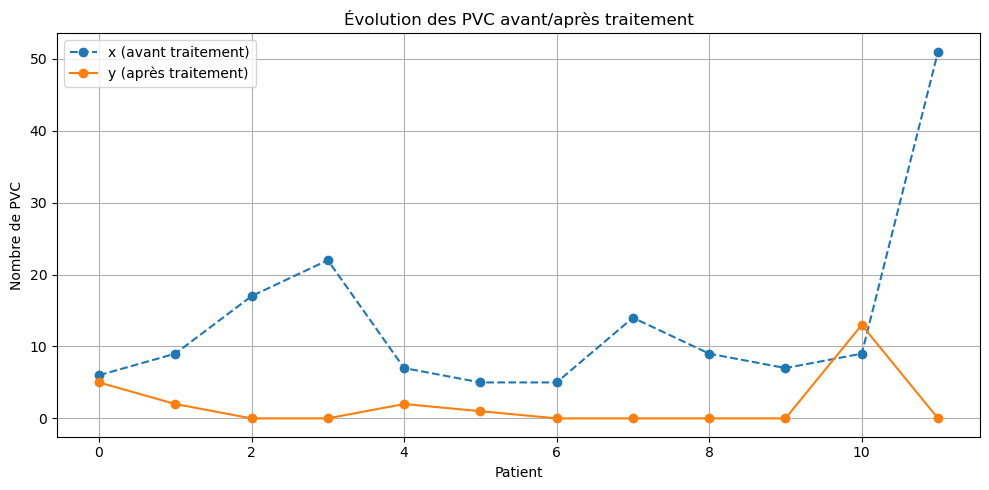

In [21]:
plt.figure(figsize=(10, 5))
plt.plot(range(len(vecteur_des_valeurs_x)), vecteur_des_valeurs_x, marker='o', label='x (avant traitement)', linestyle='--')
plt.plot(range(len(vecteur_des_valeurs_y)), vecteur_des_valeurs_y, marker='o', label='y (après traitement)')
plt.xlabel("Patient")
plt.ylabel("Nombre de PVC")
plt.title("Évolution des PVC avant/après traitement")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


fct  pr calculer la log-vraisemblance dans le modèle "cure binomial"

In [64]:
def logpmf_cure_binomiale(valeur_y, total_t, prob, taux_cure):

    if valeur_y == 0: #zero observé
        
        log_prob = log(taux_cure + (1 - taux_cure) * ((1 - prob) ** total_t))
    else: #patient non guéri
        
        coef_binomial = lgamma(total_t + 1) - lgamma(valeur_y + 1) - lgamma(total_t - valeur_y + 1)
        log_prob = log(1 - taux_cure) + coef_binomial + valeur_y * log(prob) + (total_t - valeur_y) * log(1 - prob)

    return log_prob

Modèle énoncé

In [23]:
def modele_coeur(vecteur_x, vecteur_y):

    
    param_alpha = numpyro.sample("alpha", dist.Normal(0., 10.)) # para alpha peu informatif
    param_delta = numpyro.sample("delta", dist.Normal(0., 10.)) # para delta peu informatif
    
    
    prob_p = 1.0 / (1.0 + jnp.exp(-param_alpha)) #transfo logistique
    taux_cure = 1.0 / (1.0 + jnp.exp(-param_delta))
    

    valeur_beta = jnp.exp(param_alpha)
    numpyro.deterministic("beta", valeur_beta)  # enregistrement de beta dans la trace
    numpyro.deterministic("theta", taux_cure)
    

    for indice in range(len(vecteur_x)):
        total_t = vecteur_x[indice] + vecteur_y[indice]  # somme des x & y pour l'observation i
        log_vraisemblance = logpmf_cure_binomiale(vecteur_y[indice], total_t, prob_p, taux_cure)
        numpyro.factor(f"loglike_{indice}", log_vraisemblance)

In [29]:
somme_comptages = vecteur_des_valeurs_x + vecteur_des_valeurs_y

In [65]:
def log_factoriel(nombre):

    return math.lgamma(nombre + 1)

def log_coeff_binomial(valeur_t, valeur_y):
    return log_factoriel(valeur_t) - log_factoriel(valeur_y) - log_factoriel(valeur_t - valeur_y)

def fonction_logistique(u):
    return 1.0 / (1.0 + math.exp(-u))

Log-vraisemblance

In [31]:
def log_vraisemblance_modele(param_alpha, param_delta):
    p = fonction_logistique(param_alpha)
    theta = fonction_logistique(param_delta)
    log_vraisemblance = 0.0
    
    for i in range(n):
        if vecteur_des_valeurs_y[i] == 0:
            valeur = theta + (1.0 - theta) * ((1.0 - p) ** somme_comptages[i])
            if valeur <= 0:
                return -np.inf  # éviter log(0)
            log_vraisemblance += math.log(valeur)
        else:
            if (1.0 - theta) <= 0:
                return -np.inf
            log_vraisemblance += math.log(1.0 - theta)
            log_vraisemblance += log_coeff_binomial(somme_comptages[i], vecteur_des_valeurs_y[i])
            log_vraisemblance += vecteur_des_valeurs_y[i] * math.log(p) + (somme_comptages[i] - vecteur_des_valeurs_y[i]) * math.log(1.0 - p)
    
    return log_vraisemblance

Log-prior

In [32]:
def log_prior(param_alpha, param_delta):
    sigma = 10.0
    lp_alpha = -math.log(sigma * math.sqrt(2.0 * math.pi)) - (param_alpha ** 2) / (2.0 * sigma ** 2)
    lp_delta = -math.log(sigma * math.sqrt(2.0 * math.pi)) - (param_delta ** 2) / (2.0 * sigma ** 2)
    return lp_alpha + lp_delta

def log_posterieure(param_alpha, param_delta):
    return log_prior(param_alpha, param_delta) + log_vraisemblance_modele(param_alpha, param_delta)  # log de la postérieure


Algo MH du cours

In [48]:
def metropolis_hastings(n_iterations=100000, ecart_type_alpha=0.3, ecart_type_delta=0.3):
    
    chaine_alpha = np.zeros(n_iterations + 1) #stocke les chaines
    chaine_delta = np.zeros(n_iterations + 1)
    
    alpha_actuel = 0.0 #initialisation
    delta_actuel = 0.0
    log_post_actuel = log_posterieure(alpha_actuel, delta_actuel)

    chaine_alpha[0] = alpha_actuel
    chaine_delta[0] = delta_actuel

    for t in range(1, n_iterations + 1):
        
        alpha_prop = np.random.normal(alpha_actuel, ecart_type_alpha) #tirer une prop
        delta_prop = np.random.normal(delta_actuel, ecart_type_delta)

       
        log_post_prop = log_posterieure(alpha_prop, delta_prop) #calcul proba acceptation
        log_acceptance_ratio = log_post_prop - log_post_actuel


        if np.log(np.random.rand()) < log_acceptance_ratio: #acceptation
            alpha_actuel = alpha_prop
            delta_actuel = delta_prop
            log_post_actuel = log_post_prop  # mise à jour


        chaine_alpha[t] = alpha_actuel #stocke valeur à l'instant t
        chaine_delta[t] = delta_actuel

    return chaine_alpha, chaine_delta


Principal

In [49]:
periode_de_rejet = 2000  # burn-in
n_iterations= 12000
chaine_alpha, chaine_delta = metropolis_hastings(n_iterations, 0.3, 0.3)

alpha_apres_burn = chaine_alpha[periode_de_rejet:]
delta_apres_burn = chaine_delta[periode_de_rejet:]

beta_apres_burn = np.exp(alpha_apres_burn)
theta_apres_burn = 1.0 / (1.0 + np.exp(-delta_apres_burn))


In [52]:
print(chaine_alpha)

[ 0.          0.          0.         ... -1.04642162 -1.04642162
 -0.92459154]


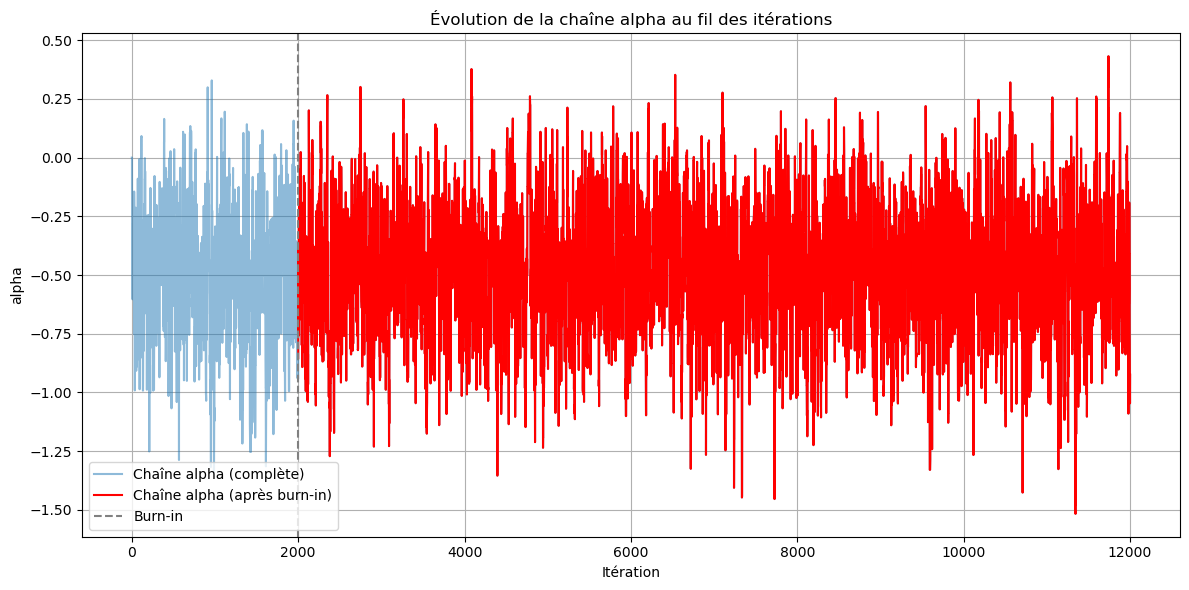

In [56]:
plt.figure(figsize=(12, 6))
plt.plot(chaine_alpha, label="Chaîne alpha (complète)", alpha=0.5)
plt.plot(range(periode_de_rejet, n_iterations+1), alpha_apres_burn, label="Chaîne alpha (après burn-in)", color="red")
plt.axvline(x=periode_de_rejet, color='gray', linestyle='--', label="Burn-in")
plt.xlabel("Itération")
plt.ylabel("alpha")
plt.title("Évolution de la chaîne alpha au fil des itérations")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

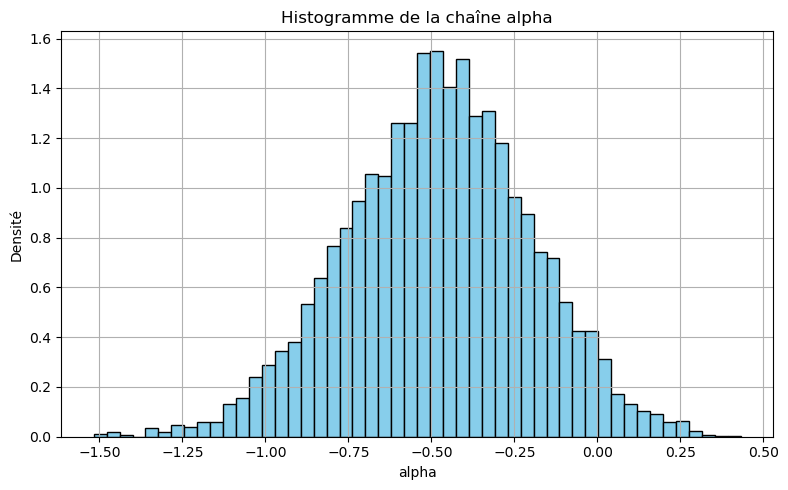

In [59]:
plt.figure(figsize=(8, 5))
plt.hist(chaine_alpha, bins=50, color='skyblue', edgecolor='black', density=True)
plt.title("Histogramme de la chaîne alpha")
plt.xlabel("alpha")
plt.ylabel("Densité")
plt.grid(True)
plt.tight_layout()
plt.show()

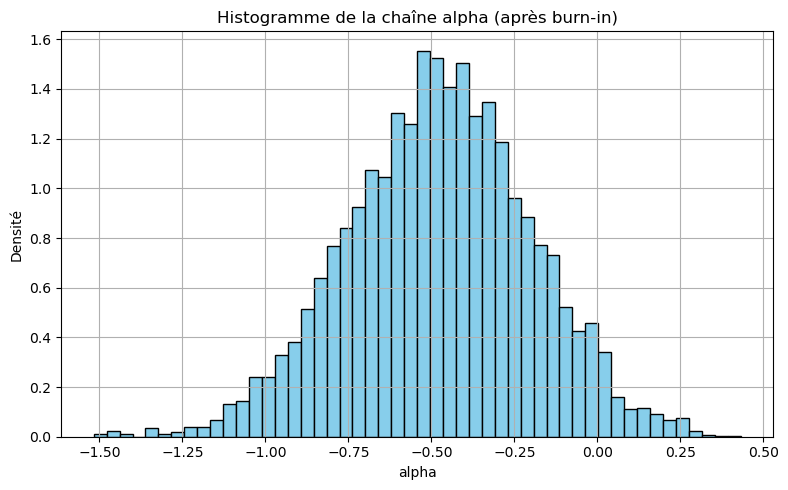

In [58]:
plt.figure(figsize=(8, 5))
plt.hist(alpha_apres_burn, bins=50, color='skyblue', edgecolor='black', density=True)
plt.title("Histogramme de la chaîne alpha (après burn-in)")
plt.xlabel("alpha")
plt.ylabel("Densité")
plt.grid(True)
plt.tight_layout()
plt.show()

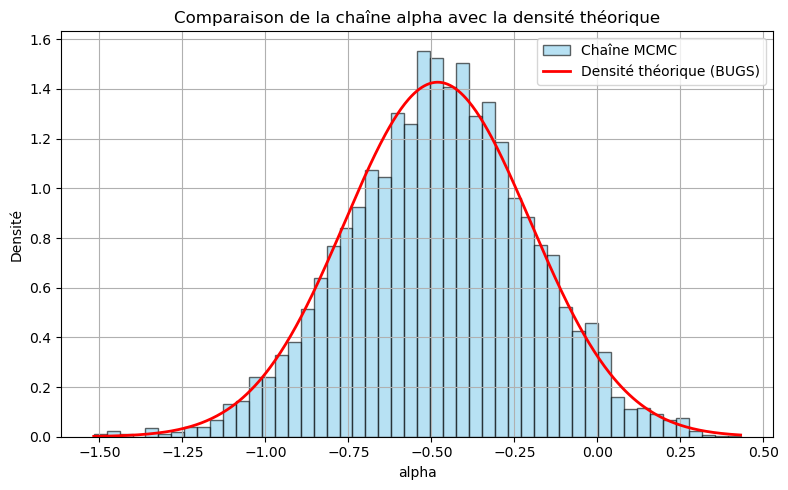

In [62]:
mu_alpha = -0.4809
sigma_alpha = 0.2795

# Valeurs pour x
x_vals = np.linspace(min(alpha_apres_burn), max(alpha_apres_burn), 500)
densite_theorique = norm.pdf(x_vals, loc=mu_alpha, scale=sigma_alpha)

plt.figure(figsize=(8, 5))
plt.hist(alpha_apres_burn, bins=50, density=True, color='skyblue', edgecolor='black', alpha=0.6, label='Chaîne MCMC')
plt.plot(x_vals, densite_theorique, 'r-', lw=2, label='Densité théorique (BUGS)')
plt.title("Comparaison de la chaîne alpha avec la densité théorique")
plt.xlabel("alpha")
plt.ylabel("Densité")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

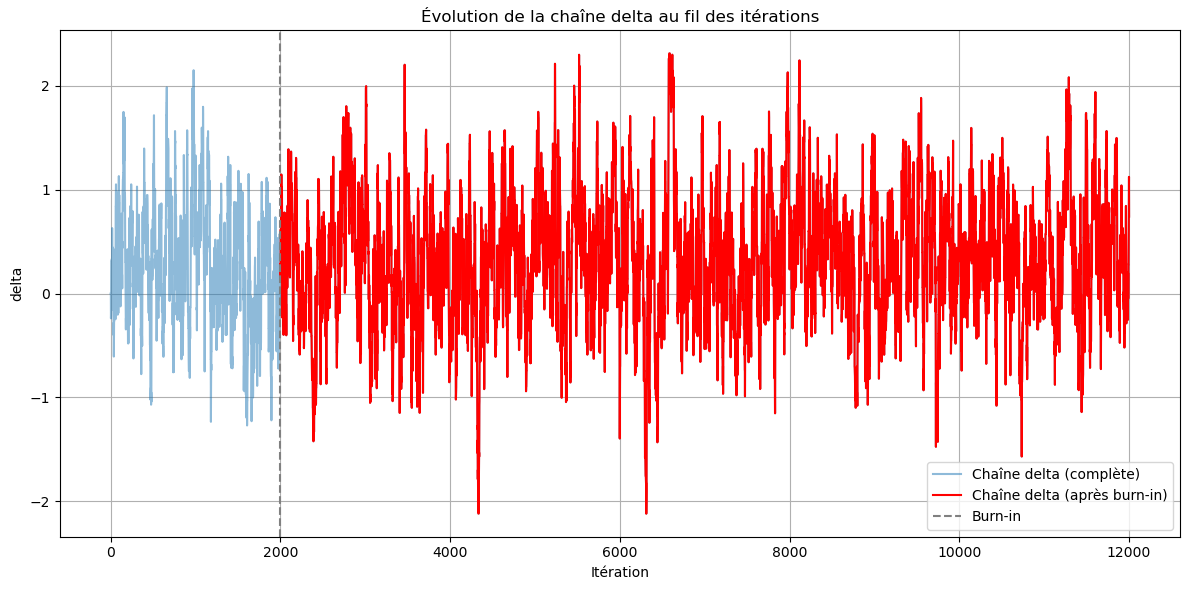

In [57]:
plt.figure(figsize=(12, 6))
plt.plot(chaine_delta, label="Chaîne delta (complète)", alpha=0.5)
plt.plot(range(periode_de_rejet, n_iterations+1), delta_apres_burn, label="Chaîne delta (après burn-in)", color="red")
plt.axvline(x=periode_de_rejet, color='gray', linestyle='--', label="Burn-in")
plt.xlabel("Itération")
plt.ylabel("delta")
plt.title("Évolution de la chaîne delta au fil des itérations")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [50]:
print("Taille post-burn-in:", len(alpha_apres_burn))
print("Moyenne de alpha = %.4f" % np.mean(alpha_apres_burn))
print("Moyenne de beta  = %.4f" % np.mean(beta_apres_burn))
print("Moyenne de delta = %.4f" % np.mean(delta_apres_burn))
print("Moyenne de theta = %.4f" % np.mean(theta_apres_burn))

intervalle_beta = np.percentile(beta_apres_burn, [2.5, 97.5])
intervalle_theta = np.percentile(theta_apres_burn, [2.5, 97.5])
print("Intervalle 95%% de beta: [%.3f, %.3f]" % (intervalle_beta[0], intervalle_beta[1]))
print("Intervalle 95%% de theta: [%.3f, %.3f]" % (intervalle_theta[0], intervalle_theta[1]))


Taille post-burn-in: 10001
Moyenne de alpha = -0.4771
Moyenne de beta  = 0.6446
Moyenne de delta = 0.3272
Moyenne de theta = 0.5747
Intervalle 95% de beta: [0.356, 1.045]
Intervalle 95% de theta: [0.293, 0.823]


Graphe des predictive checks pour MH

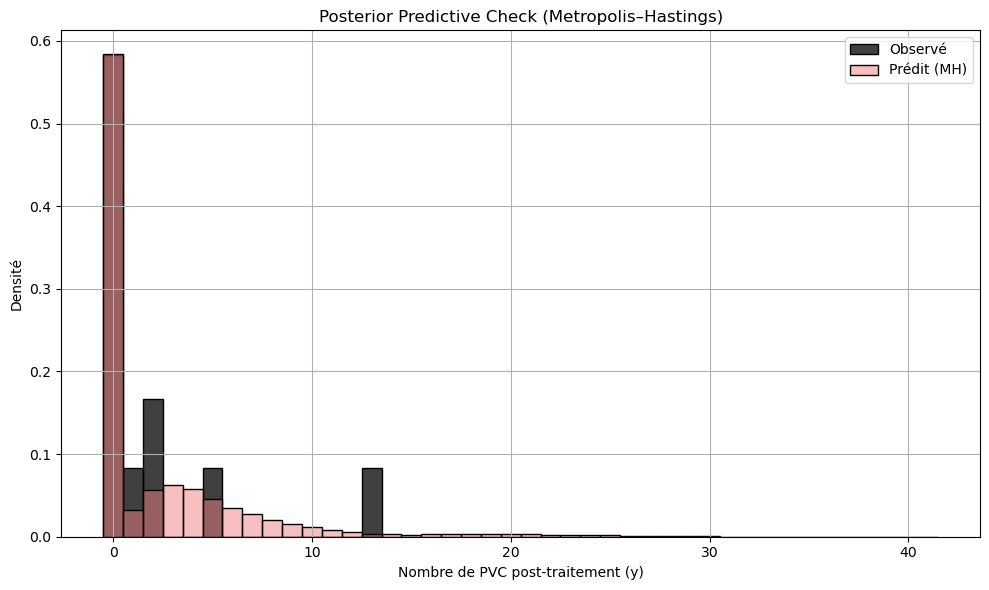

In [51]:
n_samples = len(beta_apres_burn)
y_pred_mh = []

for i in range(n_samples):
    beta = beta_apres_burn[i]
    theta = theta_apres_burn[i]
    p = beta / (1 + beta)
    
    for j in range(n):
        t_ij = vecteur_des_valeurs_x[j] + vecteur_des_valeurs_y[j]
        if np.random.rand() < theta:
            y_pred_mh.append(0)
        else:
            y_pred_mh.append(np.random.binomial(t_ij, p))

plt.figure(figsize=(10, 6))
sns.histplot(vecteur_des_valeurs_y, bins=range(0, max(vecteur_des_valeurs_y)+2), color='black', label='Observé', stat="density", discrete=True)
sns.histplot(y_pred_mh, bins=range(0, max(vecteur_des_valeurs_y)+2), color='lightcoral', label='Prédit (MH)', stat="density", alpha=0.5, discrete=True)
plt.xlabel("Nombre de PVC post-traitement (y)")
plt.ylabel("Densité")
plt.title("Posterior Predictive Check (Metropolis–Hastings)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()